<a href="https://colab.research.google.com/github/SveBB/Notebooks/blob/main/classification_of_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Аналитик данных - тестовое задание
## Задача:
Выполнить парсинг отзывов с [сайта](https://tabiturient.ru/sliv/n/?12) (12-4600)
Получить таблицу

| Вуз | Дата | Текст | N-лайков | Тональность |
|-----|------|-------|----------|-------------|
|Name |Date  |Review |Likes     |0 or 1 or 2  |

На основе полученных данных обучить любой алгоритм машинного обучения для прогнозирования тональности.


## Парсинг сайта

In [ ]:
#Подключение библиотек
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime

#Создание хранилища
columns = ['university', 'date', 'text', 'likes', 'tonality']
df = pd.DataFrame(columns=columns)

#Данные и функция для обработки даты
today = datetime.datetime.now()
def monthToNum(shortMonth):
    return {'января'  : '1', 'февраля' : '2', 'марта'   : '3',
            'апреля'  : '4', 'мая'     : '5', 'июня'    : '6',
            'июля'    : '7', 'августа' : '8', 'сентября': '9', 
            'октября' : '10', 'ноября'  : '11','декабря' : '12'}[shortMonth]

recent_days = ['Сегодня', 'Вчера', 'Позавчера']

def date_handle(date):
    if date in ['Сегодня', 'Вчера', 'Позавчера']:
        if date == 'Сегодня':
            return(today.strftime("%Y-%m-%d"))
        if date == 'Вчера':
            DD = datetime.timedelta(days=1)
            earlier = today - DD
            return(earlier.strftime("%Y-%m-%d"))
        if date == 'Вчера':
            DD = datetime.timedelta(days=2)
            earlier = today - DD
            return(earlier.strftime("%Y-%m-%d"))
    else:
        date = date.split(' ')
        return "-".join([date[2], monthToNum(date[1]), date[0]])

#Функция обработки ответов с сайта
def get_review_data_test(review_id):
    data = {'university': '', 'date': '',
            'text': '', 'likes': '',
            'tonality': ''}
    
    url = 'https://tabiturient.ru/sliv/n/?%d' % (review_id)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    if soup.find('h1', {'class': 'font4 fontshadow1'}).text == 'Такого отзыва не существует':
        data = {'university': None,
                'date': None,
                'text': None,
                'likes': None,
                'tonality': None}
    else:
        try:
            data['university'] = soup.find('td', {'class': 'w100mobile'}).b.text
        except AttributeError:
            data['university'] = soup.find('h1', {'class': 'font4 fontshadow1'}).text
        
        data['date'] = date_handle(soup.find('div', {'class': 'table-4'}).find_all('span')[-1].text.replace("\n", ""))
        data['text'] = soup.find('div', {'class': 'font2'}).text
        like_id = 'likeval%d' % (review_id)
        data['likes'] = soup.find(id=like_id).text

        tonality = {'smile1.png': 'positive',
                    'smile2.png': 'negative',
                    'smile3.png': 'neutral'}
        data['tonality'] = tonality[soup.find('table', {'class': 'avatarask2'}).img['src'].split('/')[-1]]

    return data

for i in range(12, 4601):
    df.loc[i] = get_review_data_test(i)
    print(i ,"запрос обработан", end = '\r')

df.to_csv('reviews.csv', index=True)

## Предобработка

In [ ]:
#Подключение библиотек
import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")
#Чтение данных
df = pd.read_csv('reviews.csv', index_col = 'Unnamed: 0')
df.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SveBB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(4589, 5)

In [ ]:
#Удаление строк без отзывов
df = df[df['university'].notna()]
df.shape

(2076, 5)

In [ ]:
#В некоторых названиях учебных заведений содержиться "Отзыв о ..." необходимо убрать данную часть
def preprocess_university(name):
    name_split = name.split(' ')
    if name_split[0] == 'Отзыв':
        return ' '.join(name_split[3:])
    else:
        return name
df['university'] = df['university'].apply(lambda x: preprocess_university(x))
#negative -> 0
#neutral  -> 1
#positive -> 2
df['tonality'] = df['tonality'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))

Создадим корпус и отобразим облако слов

<ipython-input-94-e038b5efdc15>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


<AxesSubplot:>

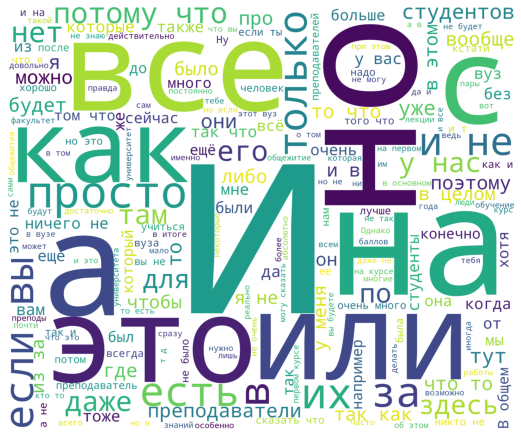

In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

При обзоре облака слов заметно что тексты содержат много лишней информации, попробуем очистить текст

In [ ]:
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

df['text_clean'] = df['text'].map(lambda x: x.lower())
df['text_clean'] = df['text_clean'].map(lambda x: remove_punct(x))
df['text_clean'] = df['text_clean'].map(lambda x: x.replace("\n", ""))
df['text_clean'] = df['text_clean'].map(lambda x: x.split(' '))
df['text_clean'] = df['text_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
df['text_clean'] = df['text_clean'].map(lambda x: ' '.join(x))

<ipython-input-98-699a9a962a68>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


<AxesSubplot:>

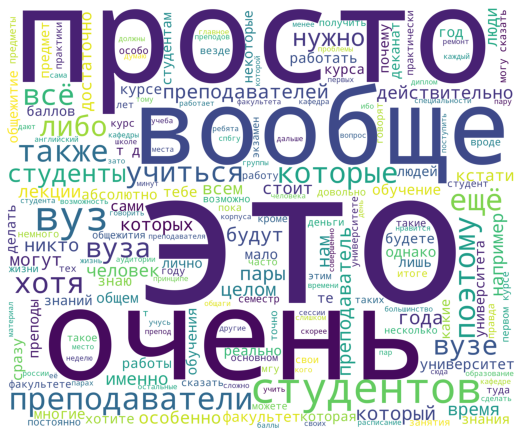

In [ ]:
corpus = get_corpus(df['Post_clean'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

## Обучение модели

Разделение выборки на тренировочную, валидационную и тестовую

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df['text_clean'], df['tonality'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Для обучения используем линейный классификатор и метод к-ближайших соседей

Подключим необходимые модули из sklearn

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
sgd_ppl_clf.fit(X_train, y_train)
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

Результаты линейного классификатора

In [ ]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       225
           1       0.13      0.40      0.20        25
           2       0.76      0.63      0.69       124

    accuracy                           0.71       374
   macro avg       0.60      0.61      0.58       374
weighted avg       0.81      0.71      0.75       374



Результаты по методу к-ближайших соседей

In [ ]:
predicted_sgd = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       235
           1       0.14      0.58      0.23        19
           2       0.67      0.57      0.61       120

    accuracy                           0.66       374
   macro avg       0.56      0.62      0.54       374
weighted avg       0.76      0.66      0.70       374



Резульаты линейного классификатора немного лучше, поэтому проведём для него кроссвалидацию

In [ ]:
parameters = { 
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_valid, y_valid)
print(model.best_score_, model.best_params_)


0.7067307692307692 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'elasticnet', 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': None}


In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', loss = 'hinge', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       214
           1       0.16      0.50      0.24        24
           2       0.80      0.60      0.69       136

    accuracy                           0.71       374
   macro avg       0.61      0.64      0.59       374
weighted avg       0.81      0.71      0.75       374



Кроссвалидация не дала большого прироста метрик

Далее рассмотрим ещё одну метрику качества confusion matrix

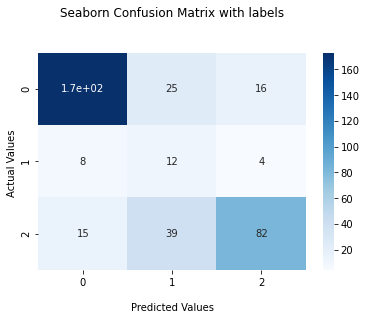

In [ ]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(predicted_sgd, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

Анализируя данную матрицу можно предположить что в данных присутствует дисбаланс классов

In [ ]:
df['tonality'].value_counts()

0    1019
2     656
1     401
Name: tonality, dtype: int64

Попробуем решить дисбаланс классов методом undersampling

In [ ]:
df2 = df[df['tonality'] == 0]
df2 = df2.sample(frac=0.6)
df2 = df2.append(df[(df['tonality'] == 1) | (df['tonality'] == 2)])
df2 = df2.sample(frac=1)

In [ ]:
df2['tonality'].value_counts()

2    656
0    611
1    401
Name: tonality, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['text_clean'], df2['tonality'], test_size=0.3, random_state=42)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', loss = 'hinge', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       200
           1       0.28      0.52      0.37        67
           2       0.82      0.72      0.77       234

    accuracy                           0.71       501
   macro avg       0.66      0.67      0.65       501
weighted avg       0.77      0.71      0.73       501



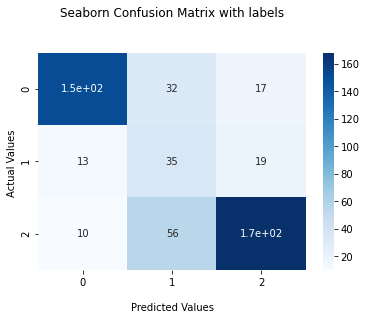

In [ ]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(predicted_sgd, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

По матрице видим что модель стала лучше различать 0 и 2 класс, также попробуем объеденить 1 и 2 класс для улучшения результатов

In [ ]:
df3 = df.copy()
def foo(x):
    if x == 2:
        return 1
    else:
        return x
df3['tonality'] = df3['tonality'].apply(lambda x: foo(x))
df3['tonality'].value_counts()

1    1057
0    1019
Name: tonality, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3['text_clean'], df3['tonality'], test_size=0.3, random_state=42)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', loss = 'hinge', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       297
           1       0.85      0.86      0.85       326

    accuracy                           0.85       623
   macro avg       0.85      0.85      0.85       623
weighted avg       0.85      0.85      0.85       623



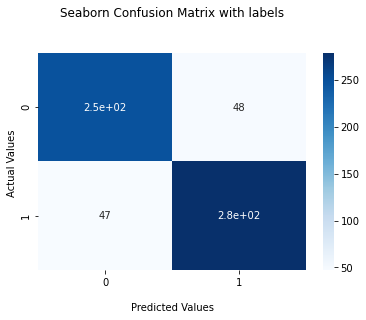

In [ ]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(predicted_sgd, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

Объединение классов улучшили результаты

Но мы попробуем улучшить резульаты по изначальной задаче с помощью лемматизации

In [ ]:
import pymorphy2

m = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    text = text.split(' ')
    lemm_text = list(map(lambda x: m.parse(x)[0].normal_form, text))
    return ' '.join(lemm_text)

df2['text_lem'] = df2['text_clean'].map(lambda x: lemmatization(x))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['text_lem'], df2['tonality'], test_size=0.3, random_state=42)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', loss = 'hinge', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       197
           1       0.24      0.44      0.31        68
           2       0.83      0.72      0.77       236

    accuracy                           0.70       501
   macro avg       0.64      0.64      0.63       501
weighted avg       0.76      0.70      0.72       501



              precision    recall  f1-score   support

           0       0.87      0.76      0.81       200
           1       0.28      0.52      0.37        67
           2       0.82      0.72      0.77       234

    accuracy                               0.71       501
    macro avg          0.66      0.67      0.65       501
    weighted avg       0.77      0.71      0.73       501

Видно что результаты немного ухудшились, добавим лемматизацию к варианту с объединением классов

In [ ]:
df3['text_lem'] = df3['text_clean'].map(lambda x: lemmatization(x))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3['text_lem'], df3['tonality'], test_size=0.3, random_state=42)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', loss = 'hinge', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       300
           1       0.88      0.89      0.89       323

    accuracy                           0.88       623
   macro avg       0.88      0.88      0.88       623
weighted avg       0.88      0.88      0.88       623



## Вывод

По результатам работы был выполнен парсинг сайта с отзывами о вузах. Данные были собраны в таблицу и обработаны. Были обучены две модели (линейный классификатор и к-ближайших соседей). Из них был выбран метод линейный классификатор, для которого была проведена кросс-валидация. Был обнаружен дисбаланс классов, для решения дисбаланса были испробованы методы undersampling и объеденение классов. Для обоих вариантов результаты были улучшены с помощью лемматизации.

## Лучшие результаты

### Undersampling

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       200
           1       0.28      0.52      0.37        67
           2       0.82      0.72      0.77       234

        accuracy                           0.71       501
       macro avg       0.66      0.67      0.65       501
    weighted avg       0.77      0.71      0.73       501


### Объединение классов

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       300
           1       0.88      0.89      0.89       323

        accuracy                           0.88       623
       macro avg       0.88      0.88      0.88       623
    weighted avg       0.88      0.88      0.88       623

In [ ]:
df.to_csv('final.csv')